<a href="https://colab.research.google.com/github/AzraSaf/NutriSense/blob/Ayyub/ayyub_work/DSGP_Deficiency_Validations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from google.colab import drive
import numpy as np
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/My Drive/coffee dataset/CoLeaf DATASET/'

# Updated deficiency classes including "other"
deficiency_classes = ['iron-Fe', 'magnesium-Mg', 'potasium-K', 'other']

# Image parameters
img_size = (224, 224)
batch_size = 32
epochs = 50

# Create the model
def create_model(num_classes):
    # Base model - ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

# Create data generators with augmentation
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 20% for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create the generators
train_generator = datagen_train.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=deficiency_classes,
    subset='training',
    shuffle=True
)

validation_generator = datagen_train.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=deficiency_classes,
    subset='validation',
    shuffle=False
)

# Calculate class weights to handle imbalanced dataset
total_samples = sum([len(os.listdir(os.path.join(dataset_path, c))) for c in deficiency_classes])
class_weights = {i: total_samples / (len(deficiency_classes) * len(os.listdir(os.path.join(dataset_path, c))))
                for i, c in enumerate(deficiency_classes)}

# Create and compile the model
model = create_model(len(deficiency_classes))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_checkpoint.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

# Save the final model
model.save("coffee_deficiency_model_with_other.h5")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
# Generate predictions for validation data
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=deficiency_classes))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=deficiency_classes,
            yticklabels=deficiency_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save model architecture and weights separately (optional)
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")

print("Training completed and model saved successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 723 images belonging to 4 classes.
Found 179 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1303 - auc: 0.3417 - loss: 74.4321 

23/23 ━━━━━━━━━━━━━━━━━━━━ 356s 15s/step - accuracy: 0.1307 - auc: 0.3412 - loss: 74.2586 - val_accuracy: 0.1173 - val_auc: 0.3210 - val_loss: 4.2042 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2008 - auc: 0.3753 - loss: 37.0596

23/23 ━━━━━━━━━━━━━━━━━━━━ 265s 11s/step - accuracy: 0.2004 - auc: 0.3754 - loss: 37.1590 - val_accuracy: 0.2011 - val_auc: 0.3356 - val_loss: 3.5431 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 250s 11s/step - accuracy: 0.2226 - auc: 0.4031 - loss: 33.1072 - val_accuracy: 0.1620 - val_auc: 0.3777 - val_loss: 3.8389 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 252s 11s/step - accuracy: 0.1752 - auc: 0.3923 - loss: 36.6822 - val_accuracy: 0.1397 - val_auc: 0.4082 - val_loss: 3.4012 - learning_rate: 0.0010
Epoch 5/50
 9/23 ━━━━━━━━━━━━━━━━━━━━ 2:29 11s/step - accuracy: 0.2183 - auc: 0.4788 - loss: 31.9792

KeyboardInterrupt: 

Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 902 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5974 - loss: 1.7512 - val_accuracy: 0.8222 - val_loss: 0.4555
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7790 - loss: 0.6010 - val_accuracy: 0.8889 - val_loss: 0.3950
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8371 - loss: 0.4585 - val_accuracy: 0.8889 - val_loss: 0.3664
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8247 - loss: 0.4238 - val_accuracy: 0.9111 - val_loss: 0.3328
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8656 - loss: 0.3727 - val_accuracy: 0.9000 - val_loss: 0.3609
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8528 - loss: 0.3509 - val_accuracy: 0.9000 - val_loss: 0.2935
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8642 - loss: 0.3210 - val_accuracy: 0.9000 - val_loss: 0.3048
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8736 - loss: 0.2954 - val_accuracy: 0.9111 - val_loss: 0.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training Set Classification Report:
              precision    recall  f1-score   support

     iron-Fe       0.88      0.89      0.88        64
magnesium-Mg       0.83      0.84      0.84        77
  potasium-K       1.00      0.73      0.84        95
       other       0.95      0.98      0.96       660

    accuracy                           0.94       896
   macro avg       0.91      0.86      0.88       896
weighted avg       0.94      0.94      0.93       896



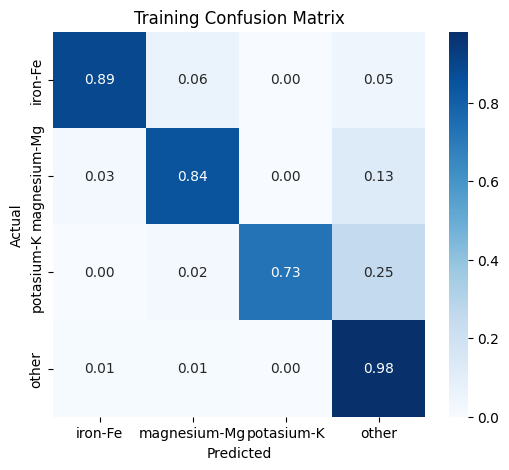

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9204 - loss: 0.2639
Validation Accuracy: 91.11%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

     iron-Fe       1.00      0.83      0.91         6
magnesium-Mg       0.70      0.88      0.78         8
  potasium-K       1.00      0.40      0.57        10
       other       0.93      1.00      0.96        66

    accuracy                           0.91        90
   macro avg       0.91      0.78      0.81        90
weighted avg       0.92      0.91      0.90        90



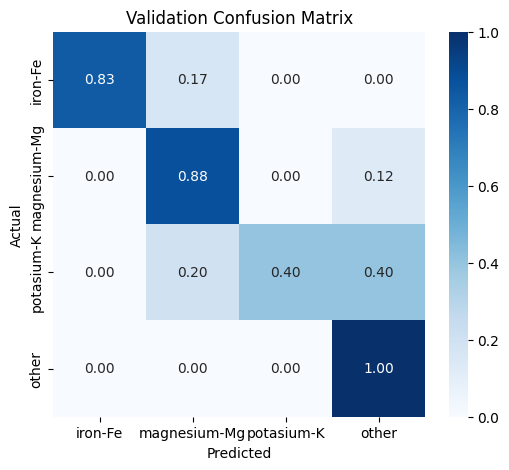

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9208 - loss: 0.2117
Test Accuracy: 88.83%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Test Set Classification Report:
              precision    recall  f1-score   support

     iron-Fe       0.70      0.54      0.61        13
magnesium-Mg       0.67      0.88      0.76        16
  potasium-K       1.00      0.68      0.81        19
       other       0.93      0.95      0.94       131

    accuracy                           0.89       179
   macro avg       0.82      0.76      0.78       179
weighted avg       0.89      0.89      0.89       179



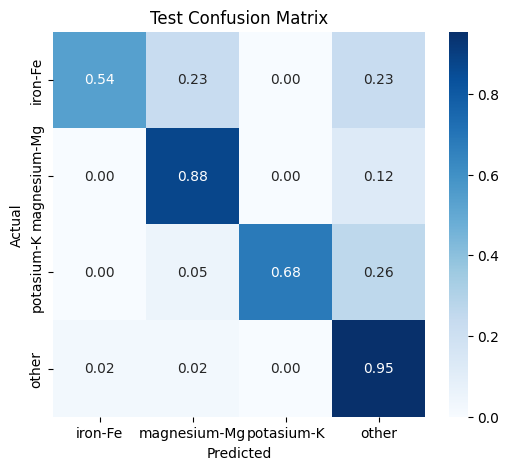

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from google.colab import drive

import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/My Drive/coffee dataset/CoLeaf DATASET/'

# Updated deficiency classes to include 'other'
deficiency_classes = ['iron-Fe', 'magnesium-Mg', 'potasium-K', 'other']

# Image parameters
img_size = (224, 224)

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Data augmentation only for the training set
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 normalization
    brightness_range=[1.0, 1.2],  # Keeping your original augmentation
    horizontal_flip=True          # Keeping your original augmentation
)

datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create separate generators for training, validation, and test sets
data_generator = datagen_val_test.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    classes=deficiency_classes,
    shuffle=False
)

# Extract features and labels from the generator
def extract_features(generator):
    features, labels = [], []
    for batch_images, batch_labels in generator:
        feature_batch = model.predict(batch_images)
        features.append(feature_batch)
        labels.append(batch_labels)
        if generator.batch_index == len(generator) - 1:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features from the dataset
features, labels = extract_features(data_generator)

# Stratified split into train (70%), test (20%), and validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, stratify=y_temp, random_state=42)

# Apply data augmentation only to training images (before feature extraction)
train_generator = datagen_train.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    classes=deficiency_classes,
    subset='training',
    shuffle=True
)

# Extract augmented training features and labels
X_train_aug, y_train_aug = extract_features(train_generator)

# Build the classifier
classifier = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(X_train_aug.shape[1],)),
    Dropout(0.5),
    Dense(len(deficiency_classes), activation='softmax')  # Updated to include 'other' class
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history = classifier.fit(X_train_aug, y_train_aug, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save the classifier
classifier.save("coffee_model.h5")

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=deficiency_classes,
                yticklabels=deficiency_classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title} Confusion Matrix')
    plt.show()

# Training Accuracy
y_train_pred = classifier.predict(X_train_aug)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_aug, axis=1)

print("\nTraining Set Classification Report:")
print(classification_report(y_train_true_classes, y_train_pred_classes, target_names=deficiency_classes))
plot_confusion_matrix(y_train_true_classes, y_train_pred_classes, "Training")

# Validation Accuracy
val_loss, val_accuracy = classifier.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_val_pred = classifier.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=deficiency_classes))
plot_confusion_matrix(y_val_true_classes, y_val_pred_classes, "Validation")

# Test Accuracy
test_loss, test_accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_test_pred = classifier.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

print("\nTest Set Classification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=deficiency_classes))
plot_confusion_matrix(y_test_true_classes, y_test_pred_classes, "Test")

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from google.colab import drive

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/My Drive/coffee dataset/CoLeaf DATASET/'

# Updated deficiency classes to include 'other'
deficiency_classes = ['iron-Fe', 'magnesium-Mg', 'potasium-K', 'other']

# Image parameters
img_size = (224, 224)

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(deficiency_classes), activation='softmax')(x)

# Full model
full_model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation only for the training set
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[1.0, 1.2],
    horizontal_flip=True
)

datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create separate generators for training, validation, and test sets
data_generator = datagen_val_test.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    classes=deficiency_classes,
    shuffle=False
)

# Train the model
history = full_model.fit(data_generator, epochs=10, batch_size=32)

# Save the entire model
full_model.save("coffee_full_model.h5")

print("Model saved successfully as 'coffee_full_model.h5'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 902 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 278s 9s/step - accuracy: 0.5176 - loss: 3.8716
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 270s 9s/step - accuracy: 0.7357 - loss: 1.1307
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - accuracy: 0.6873 - loss: 0.7654
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 289s 10s/step - accuracy: 0.7236 - loss: 0.8826
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - accuracy: 0.7303 - loss: 0.7687
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 320s 9s/step - accuracy: 0.6598 - loss: 0.7902
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 313s 9s/step - accuracy: 0.7988 - loss: 0.5374
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 264s 9s/step - accuracy: 0.6246 - loss: 0.8360
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 268s 9s/step - accuracy: 0.8310 - loss: 0.4982
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 262s 9s/step - accuracy: 0.6887 - loss: 0.7284


Model saved successfully as 'coffee_full_model.h5'


In [6]:
from google.colab import files

files.download("coffee_full_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class weights: {0: 166.25, 1: 166.25, 2: 166.25, 3: 0.25113293051359514}
Found 723 images belonging to 4 classes.
Found 179 images belonging to 4 classes.
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 337s 14s/step - accuracy: 0.3536 - loss: 58.2324 - val_accuracy: 0.2905 - val_loss: 1.8101 - learning_rate: 0.0010
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 305s 13s/step - accuracy: 0.4003 - loss: 27.9302 - val_accuracy: 0.3966 - val_loss: 1.5288 - learning_rate: 0.0010
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 310s 13s/step - accuracy: 0.4519 - loss: 20.8525 - val_accuracy: 0.2905 - val_loss: 2.3305 - learning_rate: 0.0010
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 283s 12s/step - accuracy: 0.3898 - loss: 22.6056 - val_accuracy: 0.2402 - val_loss: 3.2868 - learning_rate: 0.0010
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 282s 12s/step - accuracy: 0.4226 - loss: 19.1287 - val_accuracy: 0

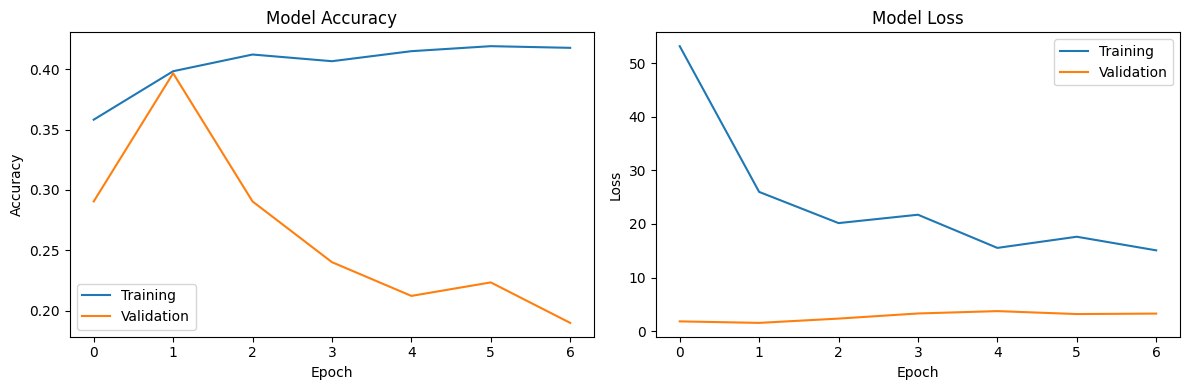

6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step

Validation Set Classification Report:
              precision    recall  f1-score   support

     iron-Fe       0.24      0.69      0.36        13
magnesium-Mg       0.22      0.67      0.33        15
  potasium-K       0.07      0.16      0.10        19
       other       0.79      0.33      0.47       132

    accuracy                           0.37       179
   macro avg       0.33      0.46      0.31       179
weighted avg       0.62      0.37      0.41       179



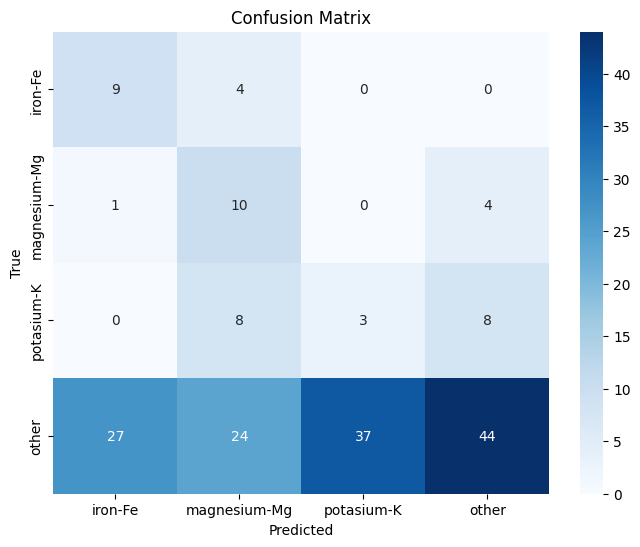


Model saved as 'coffee_full_model.h5'


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
import numpy as np
import random
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Drive
drive.mount('/content/drive')

# Path to dataset
dataset_path = '/content/drive/My Drive/coffee dataset/CoLeaf DATASET/'

# Classes
deficiency_classes = ['iron-Fe', 'magnesium-Mg', 'potasium-K', 'other']

# Image parameters
img_size = (224, 224)

# Calculate class weights (simplified)
def calculate_class_weights(directory, classes):
    samples_per_class = {c: len(os.listdir(os.path.join(directory, c))) for c in classes}
    total = sum(samples_per_class.values())
    return {i: total / (len(classes) * count) for i, count in enumerate(samples_per_class.values())}

class_weights = calculate_class_weights(dataset_path, deficiency_classes)
print("Class weights:", class_weights)

# Data augmentation (moderate)
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    validation_split=0.2
)

datagen_val_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
train_generator = datagen_train.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    classes=deficiency_classes,
    subset='training',
    shuffle=True
)

validation_generator = datagen_train.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    classes=deficiency_classes,
    subset='validation',
    shuffle=False
)

# Simplified but effective model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(deficiency_classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

# Save model
model.save("coffee_full_model.h5")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Print classification report
print("\nValidation Set Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=deficiency_classes))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=deficiency_classes,
            yticklabels=deficiency_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nModel saved as 'coffee_full_model.h5'")